# Testing of overlap and sum
Processing for FRB searches is usually in blocks. We consider the problem of an FRB that starts in one block and finishes in a different block and develop the overlap-and-sum routine to handle this.


In [1]:
%matplotlib inline
import numpy as np
import fdmt # you'll need to have ../python in  you PYTHONPATH
from pylab import *
import simfrb # in same directory as fdmt
reload(fdmt)

<module 'fdmt' from '/Users/ban115/bolton/craft/code/python/fdmt.pyc'>

In [2]:
# Define some constants and make an FDMT
nf = 256 # number of channels - must be a power of 2 currently.
fmax = 1440. #  Freuency of the top of the band in MHz
df = 1.0 # Channel bandwidth in MHz
fmin = fmax - nf*df # Frequency of the bottom of the band in MHz
nd = 1024 # Number of DM trials to do
nt = 256 # Number of samples per block
tsamp = 1.0 # milliseconds
thefdmt = fdmt.Fdmt( fmin, df, nf, nd, nt) # make FDMT

Iteration 1 2.0 2.0 2.0 False
Iteration 2 4.0 4.0 4.0 False
Iteration 3 8.0 8.0 8.0 False
Iteration 4 16.0 16.0 16.0 False
Iteration 5 32.0 32.0 32.0 False
Iteration 6 64.0 64.0 64.0 False
Iteration 7 128.0 128.0 128.0 False
Iteration 8 256.0 256.0 256.0 False


In [3]:
# utility function:
def printmax(fout):
    maxidx = fout.argmax()
    idtmax, tmax = np.unravel_index(maxidx, fout.shape)
    vmax = fout[idtmax, tmax]
    print("Maximum of %f at idt=%d t=%d" % (vmax, idtmax, tmax))
    
    return (vmax, idtmax, tmax)

def plot_blocks(blocks, title, mask_zero=False, **kwargs):
    nblocks = len(blocks)
    fig, ax = subplots(1, nblocks, figsize=(10, 7))
    
    for b in range(nblocks):
        ax[b].set_title('{} {}'.format(title, b))
        ax[b].set_xlabel('t')
        if mask_zero:
            d = np.ma.masked_equal(blocks[b], 0)
        else:
            d = blocks[b]
        ax[b].imshow(d, aspect='auto', origin='lower', **kwargs)
        
    ax[0].set_ylabel('IDT')


shape=(256, 512) sum=324.437488904 DM =300.31 pc/cc = 288.000537136 samples


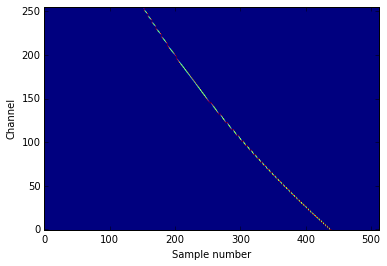

In [4]:
# Caution: The DM units here are in pc/cm3 and the DM units the FDMT uses are in samples. at about 1 GHz and 1 ms these are almost identical.
# We make an long FRB and chop it in half
dm_pccc = 300.31 # DM in pc/cc
dm_idt = 4.15*dm_pccc*((fmin/1e3)**-2 - (fmax/1e3)**-2)/tsamp # convert dm to idt
frb = simfrb.mkfrb(fmax/1e3, -df/1e3, nf, tsamp=tsamp, dm=dm_pccc, ntimes=nt*2, offset=150).T
frb = np.flipud(frb)
print('shape={} sum={} DM ={} pc/cc = {} samples'.format(frb.shape, frb.sum(), dm_pccc, dm_idt))
imshow(frb, aspect='auto', origin='lower')
xlabel('Sample number')
ylabel('Channel')

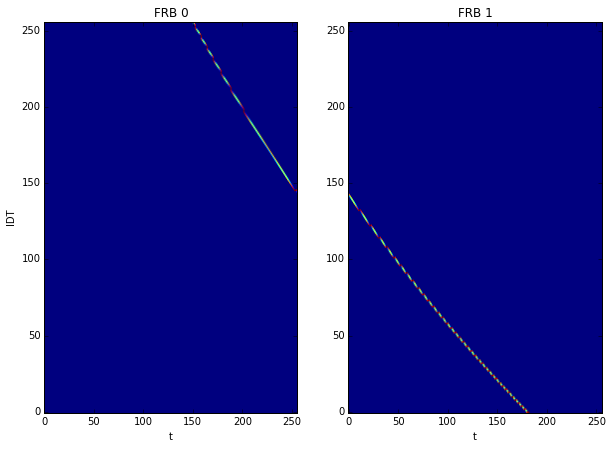

In [5]:
# now chop the FRB into 2 pieces:
block1 = frb[:, 0:nt]
block2 = frb[:, nt:2*nt]
plot_blocks([block1, block2], "FRB")

block 1
Maximum of 97.004269 at idt=287 t=436
block 2
Maximum of 174.601531 at idt=288 t=181


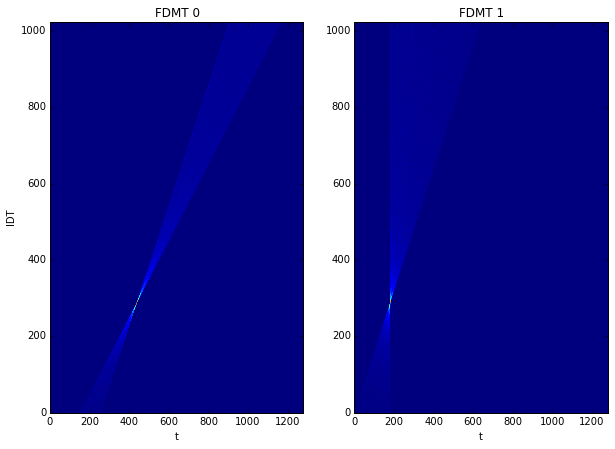

In [6]:
# Let's put each block through the FDMT
f1 = thefdmt(block1)
f2 = thefdmt(block2)
print("block 1")
printmax(f1)
print("block 2")
printmax(f2)
plot_blocks([f1, f2], 'FDMT')

OK so you can see in the first block does the dedispersion and (except for some error - needing a bit of attention later) - there's a peak in both blocks at idt=288. In the first block t=436, and the second at t=181. Recall that the FDMT time (t) is with reference to the time that the FRB goes through the final channel. In this case, the fact that the first block has the FRB arriving at t=436, is saying 436 samples from the beginning of block 1. If the block size is 256, then we'd expec to see the FRB arriving at t=436-256 = 180 samples into block 2 which is (roughly) where we see it arriving. So now what we need is for the for an overlap and sum operation to take in blocks of data and keep the output as required.

In [7]:
# spelled out here for teaching purposes, but also implemented in fdmt.OverlapAndSum 
class OverlapAndSum(object):
    def __init__(self, nd, nt, dtype=None):
        self.nd = nd
        self.nt = nt
        assert nd > 0
        assert nt > 0
        assert nd >= nt
        assert nd % nt == 0, 'Block size needs to divide into number of dispersion trials'
        self.history = np.zeros((nd, nd + nt), dtype)
        
    def process(self, block):
        nd, nt = self.nd, self.nt
        assert block.shape == (nd, nd+nt), 'Invalid block shape {}'.format(block.shape)
        
        # Update history - left most (lowest time index values) get updated to the previous history
        # shifted by nt and we add in the input block
        self.history[:, 0:nd] = self.history[:, nt:nd+nt] + block[:, 0:nd]
        
        # for times > nd, we just copy the input block in - we have nothign to add to it
        # We'll explicit with the slice boundaries here, for clarity
        self.history[:, nd:nd+nt] = block[:, nd:nd+nt]
        
        # THe output block is the first nt samples of the history
        output = self.history[:, 0:nt]
        
        return output
    

    def __call__(self, block):
        return self.process(block)
        

block 1 (1024, 1280) (1024, 256)
Maximum of 4.529779 at idt=74 t=245
block 2 (1024, 1280) (1024, 256)
Maximum of 271.605800 at idt=288 t=181


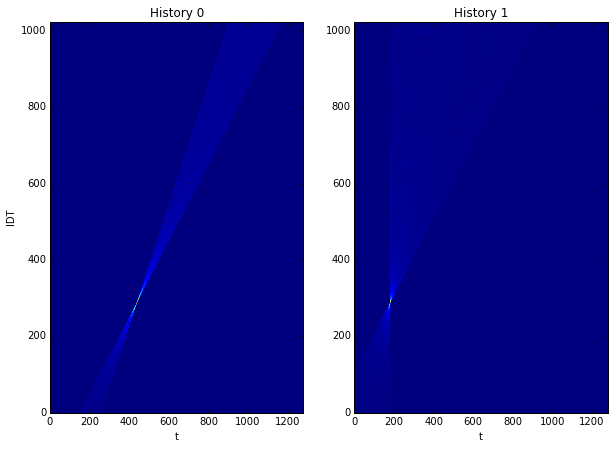

In [8]:
osum = OverlapAndSum(nd, nt)

# Let's put each block through the overlap and sum
# We're making copies because internally OverlapAndSum returns views
of1 = osum(f1).copy() 
state1 = osum.history.copy()
of2 = osum(f2).copy() 
state2 = osum.history.copy()
print("block 1", state1.shape, of1.shape)
printmax(of1)
print("block 2", state2.shape, of2.shape)
printmax(of2)

plot_blocks([state1, state2], "History")

# note how the FRB moves through the left of the history 

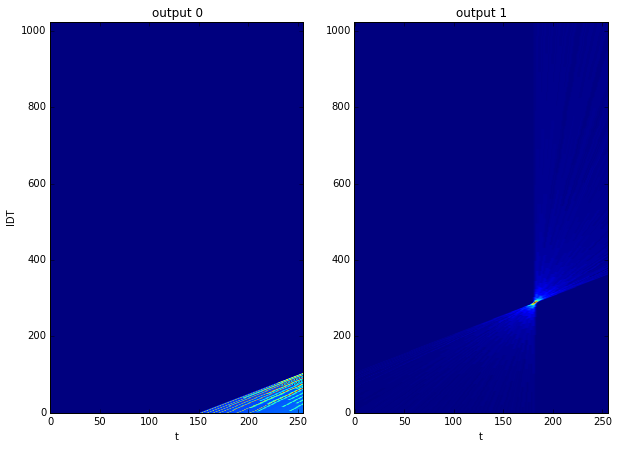

In [9]:
plot_blocks([of1, of2], "output")

In [10]:
# So how well did we do? We should have the peak in output 2 should equal the sum of the peaks in the 2 inputs, and
# also equal to the sum over the FRB.
print('peak={:0.1f} f1max={:0.1f} f2max={:0.1f} peak/(f1+f2)={:0.1f} peak/sum(frb)={:0.2f}'.format(of2.max(),
                                                                          f1.max(), \
                                                                          f2.max(), of2.max()/(f1.max() + f2.max()), \
                                                                          of2.max()/(frb.sum())
                                                                         ))

peak=271.6 f1max=97.0 f2max=174.6 peak/(f1+f2)=1.0 peak/sum(frb)=0.84


In [11]:
# So we got to 84% hitting efficiency - which is more about the FDMT than the overlap and sum.

# For a giggle, this is what it looks like for a very long FRB
Note how for the middle blocks, the FRB neither starts or finishes in that block

shape=(256, 544) sum=324.437488904 DM =300.31 pc/cc = 288.000537136 samples


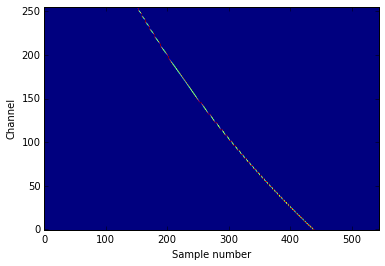

In [12]:
nt = 128
dm_pccc = 300.31 # DM in pc/cc
dm_idt = 4.15*dm_pccc*((fmin/1e3)**-2 - (fmax/1e3)**-2)/tsamp # convert dm to idt
frb = simfrb.mkfrb(fmax/1e3, -df/1e3, nf, tsamp=tsamp, dm=dm_pccc, ntimes=int(dm_idt)+2*nt, offset=150).T
frb = np.flipud(frb)
print('shape={} sum={} DM ={} pc/cc = {} samples'.format(frb.shape, frb.sum(), dm_pccc, dm_idt))
imshow(frb, aspect='auto', origin='lower')
xlabel('Sample number')
ylabel('Channel')

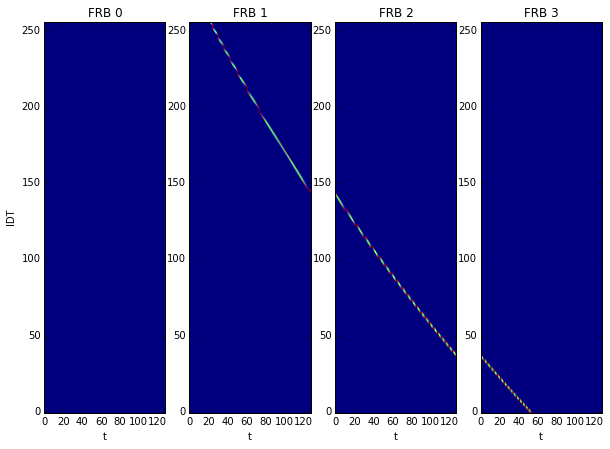

In [13]:
nblocks = frb.shape[1]/nt
blocks = [frb[:, b*nt:(b+1)*nt] for b in range(nblocks)]
plot_blocks(blocks, "FRB")


In [14]:
thefdmt = fdmt.Fdmt( fmin, df, nf, nd, nt) # make FDMT
osum = OverlapAndSum(nd, nt)
all_output = []
all_history = []
for b in range(nblocks):
    blk = blocks[b]
    fout = thefdmt(blk)
    osumout = osum(fout).copy()
    hist = osum.history.copy()
    all_output.append(osumout)
    all_history.append(hist)

Iteration 1 2.0 2.0 2.0 False
Iteration 2 4.0 4.0 4.0 False
Iteration 3 8.0 8.0 8.0 False
Iteration 4 16.0 16.0 16.0 False
Iteration 5 32.0 32.0 32.0 False
Iteration 6 64.0 64.0 64.0 False
Iteration 7 128.0 128.0 128.0 False
Iteration 8 256.0 256.0 256.0 False


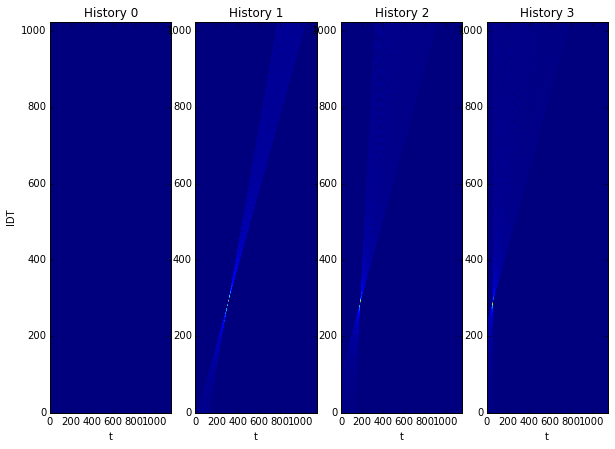

In [15]:
plot_blocks(all_history, "History")

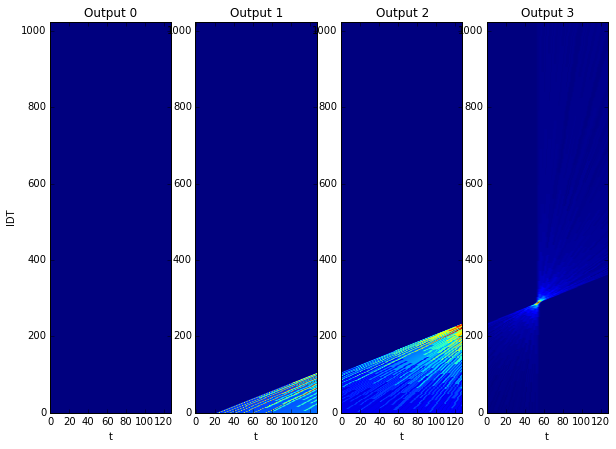

In [16]:
plot_blocks(all_output, "Output")

# Saving flops/memory
Similarly to the FDMT, the OverlapAndSum buffer isn't fully used - about half of it is always zeros. This can be seen if we do the FDMT of ones and show you what the history looks like

In [17]:
frb = np.ones((nf, nd+nt))
nblocks = frb.shape[1]/nt
blocks = [frb[:, b*nt:(b+1)*nt] for b in range(nblocks)]
thefdmt = fdmt.Fdmt( fmin, df, nf, nd, nt) # make FDMT
osum = OverlapAndSum(nd, nt)
all_output = []
all_history = []
for b in range(nblocks):
    blk = blocks[b]
    fout = thefdmt(blk)
    osumout = osum(fout).copy()
    hist = osum.history.copy()
    all_output.append(osumout)
    all_history.append(hist)

vmax = np.array(all_history).max()


Iteration 1 2.0 2.0 2.0 False
Iteration 2 4.0 4.0 4.0 False
Iteration 3 8.0 8.0 8.0 False
Iteration 4 16.0 16.0 16.0 False
Iteration 5 32.0 32.0 32.0 False
Iteration 6 64.0 64.0 64.0 False
Iteration 7 128.0 128.0 128.0 False
Iteration 8 256.0 256.0 256.0 False


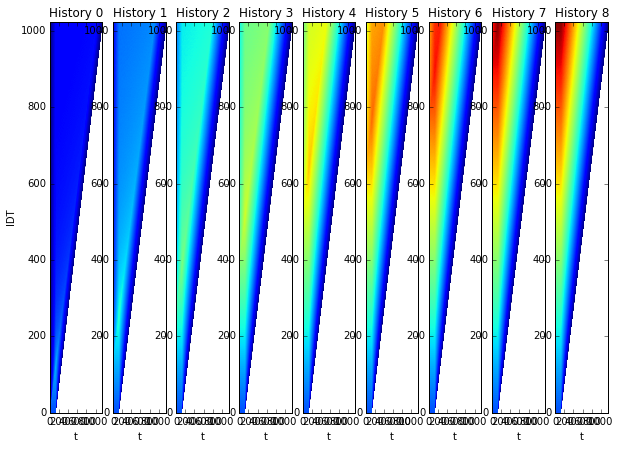

In [18]:
plot_blocks(all_history, "History", mask_zero=True, vmin=0, vmax=vmax)

That white bit that's all zeros isn't ever used by the overlap and sum - clever indexing of the history and input arrays should be able to save flos/memory by a factor of 2x